In [2]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
from shapely.geometry import Point
import shapely
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
from datetime import datetime
import numpy as np

import geopy.distance


from OSMPythonTools.api import Api as osm_api
ox.config(log_console=True, use_cache=True)

In [3]:
# Isochrone Maxspeed

start_point = (52.5153, 13.4040)
hours_of_day = range(24)
speed_aggregate = 'mean' # min, mean, max
local_set = False
path = 'travel_time+uberJan2020.graphml'

In [4]:
#G = ox.graph.graph_from_point(start_point, dist=dist, dist_type='network', network_type='drive')
#, simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)




In [5]:
if local_set:
    G = ox.graph.graph_from_place('Berlin, Germany', retain_all=True, buffer_dist=2500, network_type='drive')
    speed_df_orig = pd.read_csv('../data/Uber_speeds/movement-speeds-hourly-berlin-2020-1.csv')
else:
    G = ox.io.load_graphml(path)#, node_type=None, node_dtypes=None, edge_dtypes=None)
    

In [ ]:
# Load Uber speeds into osm Graph

if speed_aggregate == 'min':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).min()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'mean':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).mean()['speed_kph_mean'].reset_index()
elif speed_aggregate == 'max':
    speed_df = speed_df_orig.groupby(['osm_way_id','osm_start_node_id','osm_end_node_id']).max()['speed_kph_mean'].reset_index()

    
for way in speed_df.iloc():
    node_ids = [int(way['osm_start_node_id']),int(way['osm_end_node_id'])]
    try:
        G.edges[min(node_ids),max(node_ids),0]['real_speed'] = way['speed_kph_mean']
    except:
        pass


In [6]:
# Calculate Way Times for each Segment

for u, v, k, data in G.edges(data=True, keys=True):
    #print('maxspeed' in data.keys())
    if ('maxspeed' in data.keys()):
        #print(isinstance(data['maxspeed'], list))
        #print(data['maxspeed'])
        #print(type(data['maxspeed']))
        if(isinstance(data['maxspeed'], list)):
            
            
            #print(type(data['maxspeed']))
            #print(data['maxspeed'])
            speed = min(data['maxspeed'])
            #print(speed)
        else:
            speed = data['maxspeed']
    else:
        speed = 50.0
        
    if (speed == 'DE:urban'):
        speed = 50.0
    elif (speed == 'walk'):
        speed = 6.0
    elif (speed == 'none'):
        speed = 130.0
        
    #print(speed)    
    data['time'] = data['length'] / (float(speed) * 1000 / 60)
    data['maxspeed'] = float(speed)
    #print(data['test_maxspeed'])

    
    
    if ('real_speed' in data.keys()):
        real_speed = float(data['real_speed'])
    else:
        real_speed = speed
    data['real_time'] = data['length'] / (float(real_speed)* 1000 / 60)

ox.save_graphml(G, filepath='./travel_time+uberJan2020.graphml')

In [7]:
#nodes, edges = ox.graph_to_gdfs(G)
#set(list(edges['maxspeed'].values))

In [8]:
#center_node = ox.get_nearest_node(G, start_point)

#subgraph_15 = nx.ego_graph(G, center_node, radius=5, distance='time')
#subgraph_15_real = nx.ego_graph(G, center_node, radius=5, distance='real_time')

#ox.plot_graph(subgraph_15)
#ox.plot_graph(subgraph_15_real)



In [9]:
#nodes, edges = ox.graph_to_gdfs(subgraph_15_real)

#lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy

#nodes['geometry'].plot()
#zip(lat,long)[0]

#MultiPoint(nodes.reset_index()['geometry']).convex_hull
    
#dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(long,lat)]
#np.mean(dist)

In [10]:
#nodes, edges = ox.graph_to_gdfs()
#edges = edges.sort_values('time')
#nodes

In [124]:
def getAvgIsochroneDistStreet(start_point, travel_time_min, real_speed=True, plot_subgraph=False):
    x, y = Point(start_point).xy
    #print("y -> "+str(y))
    #print("x -> "+str(x))
    #start_point = [x,y]
    #print(start_point)
    center_node = ox.get_nearest_node(G, (y[0],x[0]))
    dist=[]
    distance_type = 'real_time' if real_speed else 'time'
    
    subgraph = nx.ego_graph(G, center_node, radius=travel_time_min, distance=distance_type)
    
    if plot_subgraph:
        ox.plot_graph(subgraph)
    nodes, edges = ox.graph_to_gdfs(subgraph)
    lat, long = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy
    
    dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(lat,long)]
   
    #long, lat = MultiPoint(nodes.reset_index()['geometry']).convex_hull.exterior.coords.xy
    #dist = [geopy.distance.geodesic(point,start_point).meters for point in zip(long,lat)]
    
    #for point in zip(lat,long):
    #    try:
    #        dist.append(geopy.distance.geodesic(point,start_point).meters)
    #    except:
    #        dist.append(float(0.0)
    
    return np.mean(dist)

In [125]:
#getAvgIsochroneDistStreet((52.617670, 13.223318), 5)
getAvgIsochroneDistStreet((13.223318, 52.617670), 5)

2741.3243554480105

In [126]:
def getAvgIsochroneDistStreet_list(list_of_points, travel_time_min):
    #list_of_avg = []
    #for point in list_of_points: 
        #list_of_avg.append(getAvgIsochroneDistStreet(point, travel_time_min, real_speed=True, plot_subgraph=False))
    #return list_of_avg
    return [getAvgIsochroneDistStreet(point, travel_time_min, real_speed=True, plot_subgraph=False) for point in list_of_points ]

In [127]:
list_of_points = [(13.3355015, 52.5652055),
 (13.3466053, 52.567033),
 (13.3522545, 52.567738),
 (13.339564, 52.5640768),
 (13.3429006, 52.5633975),
 (13.3373679, 52.5587807),
 (13.3306441, 52.5626152),
 (13.3277078, 52.5640457),
 (13.3202135, 52.5659103),
 (13.3460089, 52.5746796),
 (13.3521078, 52.573666),
 (13.223318, 52.617670)]

In [128]:
list_of_points

[(13.3355015, 52.5652055),
 (13.3466053, 52.567033),
 (13.3522545, 52.567738),
 (13.339564, 52.5640768),
 (13.3429006, 52.5633975),
 (13.3373679, 52.5587807),
 (13.3306441, 52.5626152),
 (13.3277078, 52.5640457),
 (13.3202135, 52.5659103),
 (13.3460089, 52.5746796),
 (13.3521078, 52.573666),
 (13.223318, 52.61767)]

In [129]:
getAvgIsochroneDistStreet_list(list_of_points, 5)

[4506.090132233297,
 4149.491464808888,
 4203.411025505457,
 4209.87430365739,
 4020.941884888438,
 4357.086723708959,
 4912.219138834144,
 4886.933472775906,
 4799.4748232026595,
 4134.692843293698,
 4276.305608664883,
 2741.3243554480105]

#  AvgIsoDistance of a PointList

<AxesSubplot:>

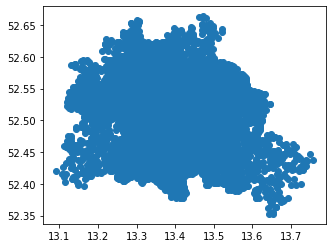

In [130]:
samplepoints = gp.read_file("../results/sample-points.geojson")
samplepoints.plot()

In [131]:
df = pd.read_json("../results/sample-points.json")
print("len ("+str(len(df))+")")
df.head(5)

len (9900)


,lon,lat
0,13.174125,52.412713
1,13.161901,52.442945
2,13.148899,52.401989
3,13.146245,52.403329
4,13.133518,52.425969


In [132]:
geodf = gp.GeoDataFrame(df)
print("len ("+str(len(geodf))+")")
geodf.head(5)

len (9900)


,lon,lat
0,13.174125,52.412713
1,13.161901,52.442945
2,13.148899,52.401989
3,13.146245,52.403329
4,13.133518,52.425969


In [133]:
#print(f'NumPy Array:\n{arr}')
list1 = geodf.values.tolist()

In [134]:
list1[1:5]

[[13.161901338074973, 52.442944744460114],
 [13.148898817301504, 52.40198937293523],
 [13.146245476951975, 52.40332926172103],
 [13.133517862921396, 52.425968953045654]]

## Wenn die Punkte nicht genug Verbindungen aufweisen bzw. ausreichend vertreten sind, kann die Convexe Hülle nicht gebaut werden und es wird eine Exception geworfen ... schwelle liegt bei 189:191 ... danach wieder partiell möglich

In [135]:
avg_iso_list = getAvgIsochroneDistStreet_list(list1[0:150], 5)
#Haesslicher Fehler ???
#avg_iso_list = getAvgIsochroneDistStreet_list(list1[182:199], 5)

In [136]:
avg_iso_list

[3628.3781959415255,
 2837.6579043388647,
 3094.084498788022,
 3208.976297993617,
 2750.6975706596036,
 4491.889788368286,
 1617.0576763053925,
 3409.845747860628,
 4334.702348841503,
 3617.1187248020797,
 4887.71085776833,
 2466.216896817992,
 3265.3757659034095,
 3214.2915999008283,
 3432.050903401288,
 2790.205657283627,
 3506.22546953351,
 2574.9519758016854,
 4226.451192305865,
 3024.091837587158,
 3528.8201097215842,
 2104.904121288704,
 3206.3719383350954,
 3926.7324790179046,
 4303.800961453869,
 3066.800105302719,
 4641.8936091952355,
 2297.9998762184964,
 4769.2339289787515,
 2917.6548866616317,
 3027.8753968768574,
 2682.844826744839,
 3607.131427782379,
 4060.5830634316885,
 4286.321188400333,
 3820.4312432657016,
 4721.6875584410445,
 1795.0914681228019,
 3094.912701551502,
 4287.741184055155,
 4531.55346036418,
 2750.0295573634235,
 4603.330406700012,
 2060.818471244114,
 3343.0113586933344,
 3472.6765829902893,
 3358.4172986574504,
 3371.6942243847107,
 5328.231101442926

In [ ]:
#geodf["avg_dist"] = avg_iso_list

In [137]:
newdf = df[0:150]

In [138]:
newdf["avg_iso_distance"] = avg_iso_list

<ipython-input-138-629fdb2b7fbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf["avg_iso_distance"] = avg_iso_list


In [140]:
newdf.describe()

,lon,lat,avg_iso_distance
count,150.000000,150.000000,150.000000
mean,13.146385,52.474740,3383.501446
std,0.021222,0.048923,835.415686
min,13.090981,52.396558,555.105029
25%,13.130082,52.426166,2795.540170
50%,13.144265,52.467208,3425.127704
75%,13.161714,52.527634,3955.454601
max,13.197869,52.552970,5328.231101
